# BeerMart Recommendation Engine

## Problem Statement

You are the sales manager for "BeerMart", an online beer store in the United States. You want to build a recommendation system (collaborative) for your store, where customers will be recommended the beer that they are most likely to buy. You collect data about the ratings that the customers have given in the past. You can download the dataset from the link below.You are the sales manager for "BeerMart", an online beer store in the United States. You want to build a recommendation system (collaborative) for your store, where customers will be recommended the beer that they are most likely to buy. You collect data about the ratings that the customers have given in the past. You can download the dataset from the link below.

In [6]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Reading ratings file
ratings = pd.read_csv(r'beer_data.csv', encoding='latin-1')

In [7]:
### Quick view of the loaded data.
ratings.head(5)

,beer_beerid,review_profilename,review_overall
0,48215,stcules,3.0
1,52159,oline73,3.0
2,52159,alpinebryant,3.0
3,52159,rawthar,4.0
4,52159,RangerClegg,3.5


### Data Analysis

In [8]:
### Get an idea of the rating spread.
ratings['review_overall'].describe()

count    475984.000000
mean          3.814827
std           0.720411
min           0.000000
25%           3.500000
50%           4.000000
75%           4.500000
max           5.000000
Name: review_overall, dtype: float64

In [9]:
ratings.shape

(475984, 3)

In [10]:
### Drop any null values for beerid or user.
ratings=ratings.dropna(subset=['beer_beerid','review_profilename'])  

In [11]:
ratings.shape

(475884, 3)

In [12]:
## Drop duplicates if any.
ratings.drop_duplicates(subset=['beer_beerid', 'review_profilename'], keep='first',inplace=True)

In [13]:
ratings.shape

(474462, 3)

In [14]:
### Find the number of ratings marked against each beer to find the optimum number N beers to be considered for further analysis.
df_count_beerid=ratings[['beer_beerid','review_overall']].groupby('beer_beerid').agg(['count'])

In [15]:
df_count_beerid.describe()

,review_overall
,count
count,40304.000000
mean,11.772082
std,41.888449
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,977.000000


In [16]:
### From the above avg number of ratings received per beer is ~>11.
### Filter out the beers which doesn't have 12 or more ratings.
counts = ratings['beer_beerid'].value_counts()
ratings=ratings[ratings['beer_beerid'].isin(counts[counts > 11].index)]

In [17]:
ratings.shape

(392172, 3)

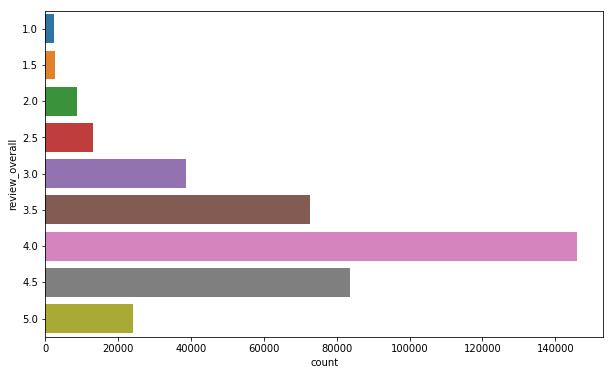

In [18]:
### Understand the frequency of rating provided . Rating 4 seems higher overall.
plt.figure(figsize=(10, 6))
sns.countplot(y="review_overall", data=ratings)
plt.show()

In [19]:
### Understand the average beer ratings :  3.757049
group_beerid=ratings.groupby('beer_beerid')
mean_beerid=group_beerid.review_overall.mean()
mean_beerid.describe()

count    6150.000000
mean        3.757049
std         0.383597
min         1.425676
25%         3.588235
50%         3.817157
75%         4.000000
max         4.875000
Name: review_overall, dtype: float64

In [ ]:
group_beerid.review_overall.agg(['count']).sort_values(by='count',ascending=False).head(20)

In [24]:
### Understand the avergae user ratings : 3.923534
group_user=ratings.groupby('review_profilename')
mean_user=group_user.review_overall.mean()
mean_user.describe()

count    21157.000000
mean         3.923534
std          0.642139
min          1.000000
25%          3.666667
50%          4.000000
75%          4.250000
max          5.000000
Name: review_overall, dtype: float64

In [104]:
group_user.review_overall.agg(['count']).sort_values(by='count',ascending=False).head(20)

,count
review_profilename,
BuckeyeNation,1016
mikesgroove,1016
northyorksammy,946
brentk56,808
WesWes,759
ChainGangGuy,756
BEERchitect,725
feloniousmonk,723
oberon,714


In [26]:
### Understand the number of ratings provided by user. 
df_count_userrating=ratings[['review_profilename','review_overall']].groupby('review_profilename').agg(['count'])
df_count_userrating.describe()
### average user has provided 18 ratings 

,review_overall
,count
count,21157.000000
mean,18.536276
std,51.449800
min,1.000000
25%,1.000000
50%,3.000000
75%,11.000000
max,1016.000000


In [54]:
### There are few users seen who have provided only 1 rating . Very less rating count from users doesnt help for recommendation.
counts = ratings['review_profilename'].value_counts()
ratings=ratings[ratings['review_profilename'].isin(counts[counts > 18].index)]

In [55]:
### Check for any null values 
ratings.isnull().values.any()

False

### Recommendation Model

In [56]:
### SPlit data into test and train sets.
from sklearn.model_selection import train_test_split
train, test = train_test_split(ratings, test_size=0.30, random_state=31)

In [57]:
print(train.shape)
print(test.shape)

(230642, 3)
(98847, 3)


In [58]:
### Creating of dummy test and train datasets for predition later.
dummy_train = train.copy()
dummy_test = test.copy()
dummy_train['review_overall'] = dummy_train['review_overall'].apply(lambda x: 0 if x>=1 else 1)
dummy_test['review_overall'] = dummy_test['review_overall'].apply(lambda x: 1 if x>=1 else 0)

In [59]:
dummy_train=dummy_train.pivot(index="beer_beerid", columns="review_profilename", values="review_overall").fillna(1)

In [60]:
dummy_test=dummy_test.pivot(index="beer_beerid", columns="review_profilename", values="review_overall").fillna(0)

### Item based similarity

#### Using adjusted Cosine similarity  

In [61]:
from sklearn.metrics.pairwise import pairwise_distances

In [62]:
df_rating_adjs = train.pivot(index='beer_beerid',columns='review_profilename',values='review_overall')

In [63]:
### normalise the ratings using mean value to subtract from the actual rating.
mean = np.nanmean(df_rating_adjs, axis=1)
df_subtracted = (df_rating_adjs.T-mean).T

In [64]:
# Beer Similarity Matrix
beer_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
beer_correlation[np.isnan(beer_correlation)] = 0
print(beer_correlation)

[[ 1.          0.01128016  0.08427162 ...  0.         -0.01074547
   0.        ]
 [ 0.01128016  1.          0.07137745 ...  0.          0.
  -0.02537957]
 [ 0.08427162  0.07137745  1.         ... -0.01093929  0.
   0.        ]
 ...
 [ 0.          0.         -0.01093929 ...  1.          0.
   0.        ]
 [-0.01074547  0.          0.         ...  0.          1.
   0.        ]
 [ 0.         -0.02537957  0.         ...  0.          0.
   1.        ]]


In [65]:
### Setting any correlation value less than 0 as 0. 
beer_correlation[beer_correlation<0]=0
beer_correlation

array([[1.        , 0.01128016, 0.08427162, ..., 0.        , 0.        ,
        0.        ],
       [0.01128016, 1.        , 0.07137745, ..., 0.        , 0.        ,
        0.        ],
       [0.08427162, 0.07137745, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [66]:
### Get the model predicted rating using correlation between beers.
beer_predicted_ratings = np.dot(beer_correlation, df_rating_adjs.fillna(0))
beer_predicted_ratings

array([[0.42079767, 0.35778642, 0.58394528, ..., 1.77558368, 0.75475388,
        0.90776436],
       [1.53791827, 0.93111179, 0.92285944, ..., 1.61676735, 0.4900536 ,
        0.79932656],
       [1.34006724, 1.1494209 , 0.68088896, ..., 2.08376285, 1.1099785 ,
        1.06662595],
       ...,
       [0.42858743, 0.53166466, 0.44116417, ..., 1.01044082, 0.28191901,
        0.11705206],
       [0.1875474 , 0.58812282, 0.14457334, ..., 0.45357215, 0.01519115,
        0.10143486],
       [0.07786005, 0.10580952, 0.0059528 , ..., 0.98504904, 0.39148623,
        0.2942164 ]])

In [67]:
### Find the ratings to be recommended to users who have not rated a beer earlier.
beer_final_rating = np.multiply(beer_predicted_ratings,dummy_train)
beer_final_rating.head()

review_profilename,0110x011,05Harley,100floods,1759Girl,1Adam12,1fastz28,1whiskey,2xHops,321jeff,32hoss32,...,zerofear13,zhanson88,zimm421,zjungleist,zoolzoo,zoso1967,zoso493,zrab11,zuggy9,zymurgy4all
beer_beerid,,,,,,,,,,,,,,,,,,,,,
5,0.420798,0.357786,0.583945,1.481388,1.227189,3.597908,0.567064,0.414181,0.868103,0.944126,...,0.987833,1.840657,0.891556,0.429717,1.122028,3.070874,2.709123,1.775584,0.754754,0.907764
6,1.537918,0.931112,0.922859,0.934191,0.554284,3.279010,0.556097,0.566667,0.600458,1.231166,...,1.753076,1.172192,1.351053,0.833652,1.161524,4.024478,1.300294,1.616767,0.490054,0.799327
7,1.340067,1.149421,0.680889,1.669960,0.245760,3.655163,0.949222,0.683047,0.786085,1.468176,...,0.000000,2.127826,1.765382,1.006034,1.397347,4.215033,1.575149,2.083763,1.109979,1.066626
8,0.215259,0.751220,0.386375,0.295960,0.010896,0.889033,0.012775,0.039795,0.144450,0.006317,...,0.817390,0.358957,0.876402,0.059174,0.260530,2.146501,0.199583,0.939741,0.150499,0.184153
9,0.180200,0.619682,0.325375,0.985881,0.472937,1.964993,0.606644,0.405282,0.016331,0.480463,...,1.110632,2.055375,1.210207,1.367324,0.316517,2.011668,0.178998,1.290271,1.298073,1.396787


In [68]:
beer_final_rating.head(10)

review_profilename,0110x011,05Harley,100floods,1759Girl,1Adam12,1fastz28,1whiskey,2xHops,321jeff,32hoss32,...,zerofear13,zhanson88,zimm421,zjungleist,zoolzoo,zoso1967,zoso493,zrab11,zuggy9,zymurgy4all
beer_beerid,,,,,,,,,,,,,,,,,,,,,
5,0.420798,0.357786,0.583945,1.481388,1.227189,3.597908,0.567064,0.414181,0.868103,0.944126,...,0.987833,1.840657,0.891556,0.429717,1.122028,3.070874,2.709123,1.775584,0.754754,0.907764
6,1.537918,0.931112,0.922859,0.934191,0.554284,3.279010,0.556097,0.566667,0.600458,1.231166,...,1.753076,1.172192,1.351053,0.833652,1.161524,4.024478,1.300294,1.616767,0.490054,0.799327
7,1.340067,1.149421,0.680889,1.669960,0.245760,3.655163,0.949222,0.683047,0.786085,1.468176,...,0.000000,2.127826,1.765382,1.006034,1.397347,4.215033,1.575149,2.083763,1.109979,1.066626
8,0.215259,0.751220,0.386375,0.295960,0.010896,0.889033,0.012775,0.039795,0.144450,0.006317,...,0.817390,0.358957,0.876402,0.059174,0.260530,2.146501,0.199583,0.939741,0.150499,0.184153
9,0.180200,0.619682,0.325375,0.985881,0.472937,1.964993,0.606644,0.405282,0.016331,0.480463,...,1.110632,2.055375,1.210207,1.367324,0.316517,2.011668,0.178998,1.290271,1.298073,1.396787
10,0.738146,1.033151,0.449526,2.112331,0.274646,3.280574,0.524629,0.534872,0.222504,1.251421,...,1.746394,1.963394,1.248891,1.239384,1.922278,3.649799,1.537197,1.912754,0.731904,1.037757
11,0.701259,0.377629,0.572941,0.449663,1.493280,3.791096,0.181465,1.305248,0.363589,2.202817,...,1.373737,1.606311,1.305969,0.410218,1.190233,2.047920,1.686009,0.264381,1.301022,0.781406
12,0.295168,0.202518,0.171145,0.534112,0.344909,2.155637,0.130269,0.255788,0.136447,0.729377,...,0.471292,0.578639,0.377336,0.244372,0.708794,0.854631,0.960852,0.256238,0.352215,0.696979
13,0.397733,0.475672,1.174590,1.530854,0.325993,2.093440,0.379363,0.342743,0.002843,0.550436,...,0.819459,0.600131,0.386972,0.676444,0.314505,1.127456,0.609410,2.191768,0.919651,0.604223


In [69]:
### Check for any pattern amongst the first 10 beers
beer_pattern=pd.DataFrame(beer_correlation).iloc[:,0:10].head(10)

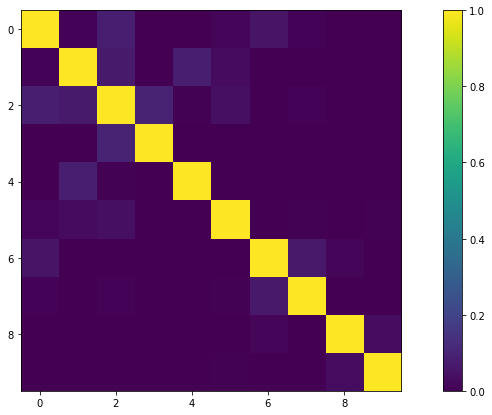

In [70]:
plt.figure(figsize=(15, 7))
plt.imshow(beer_pattern)
plt.colorbar()
plt.show()

Observation:
1. Beer 2 has some correlation/similarity with the other beers in the first 10.
2. However, overall the correlation seen is very less.

### User based similariy

In [71]:
### Load training data 
df_rating_adjs_user = train.pivot(index='beer_beerid', columns='review_profilename',values='review_overall').T
df_rating_adjs_user.head(5)

beer_beerid,5,6,7,8,9,10,11,12,13,14,...,74986,75013,75086,75160,75188,75230,75894,76144,76525,76816
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
05Harley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100floods,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1759Girl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1Adam12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
### normalise the rating using mean value.
mean = np.nanmean(df_rating_adjs_user, axis=1)
df_user_subtracted = (df_rating_adjs_user.T-mean).T

In [73]:
# User Similarity Matrix using adjusted cosine similarity 
user_correlation = 1 - pairwise_distances(df_user_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[ 1.00000000e+00  0.00000000e+00 -3.63013606e-02 ...  7.21526641e-03
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00 -4.39961320e-03 ...  2.39424878e-02
   0.00000000e+00  0.00000000e+00]
 [-3.63013606e-02 -4.39961320e-03  1.00000000e+00 ... -8.78161142e-04
  -6.95468142e-04  0.00000000e+00]
 ...
 [ 7.21526641e-03  2.39424878e-02 -8.78161142e-04 ...  1.00000000e+00
   1.05055865e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -6.95468142e-04 ...  1.05055865e-02
   1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]]


In [74]:
### Seting any correlation less than 0 as 0 as focus is only to find the positive correlations.
user_correlation[user_correlation<0]=0
user_correlation

array([[1.        , 0.        , 0.        , ..., 0.00721527, 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.02394249, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00721527, 0.02394249, 0.        , ..., 1.        , 0.01050559,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.01050559, 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [75]:
user_correlation.shape

(3933, 3933)

In [76]:
### Predict the ratings based on user correlation for all users/beers
user_predicted_ratings = np.dot((df_rating_adjs_user.fillna(0).T),user_correlation)
user_predicted_ratings

array([[ 0.88689478,  1.3614413 ,  0.52496715, ...,  2.72788839,
         3.86459375,  2.26530776],
       [ 1.43529201,  2.41484559,  1.25061428, ...,  6.42712407,
        10.0007727 ,  5.47021021],
       [ 0.97887581,  2.32561986,  0.75475946, ...,  4.53027696,
         8.01949668,  3.25659159],
       ...,
       [ 0.48926368,  0.72755447,  0.22635208, ...,  0.8565627 ,
         0.33364037,  0.38834867],
       [ 0.05008488,  0.13058175,  0.22396719, ...,  0.57784836,
         0.29398776,  0.41291042],
       [ 0.07618832,  0.55730431,  0.51540635, ...,  0.15653129,
         2.08509823,  0.31434375]])

In [77]:
user_predicted_ratings.shape

(6150, 3933)

In [78]:
### Predict the final rating only for users -beers not rated earlier using dummy train dataset.
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

review_profilename,0110x011,05Harley,100floods,1759Girl,1Adam12,1fastz28,1whiskey,2xHops,321jeff,32hoss32,...,zerofear13,zhanson88,zimm421,zjungleist,zoolzoo,zoso1967,zoso493,zrab11,zuggy9,zymurgy4all
beer_beerid,,,,,,,,,,,,,,,,,,,,,
5,0.886895,1.361441,0.524967,1.735419,0.774847,3.371239,0.478316,2.616862,1.093588,3.276802,...,3.031038,2.832257,4.234768,3.673141,2.042135,2.468427,3.393017,2.727888,3.864594,2.265308
6,1.435292,2.414846,1.250614,4.257006,2.179424,6.926800,3.590985,3.840942,2.540497,8.603237,...,5.083739,4.267673,10.730281,7.336784,3.237588,4.439361,5.037958,6.427124,10.000773,5.470210
7,0.978876,2.325620,0.754759,3.312747,1.356337,4.035198,0.685745,1.710673,1.176033,4.780809,...,0.000000,4.189141,8.908955,4.349723,2.530357,3.825801,2.755042,4.530277,8.019497,3.256592
8,0.104367,0.106982,0.191979,0.591242,0.074143,0.887297,0.182748,0.328767,0.261380,0.225596,...,0.828976,0.560398,0.729754,0.672280,0.182276,0.328402,0.376092,0.861190,0.541242,0.647438
9,0.207715,0.579396,0.062747,0.878079,0.526537,1.718244,0.829860,0.341279,0.645211,0.422477,...,1.148150,0.826376,1.353795,1.141566,0.169715,0.614520,1.301870,1.189521,1.007339,0.289546


In [79]:
### Check for any pattern amongst the first 10 users
user_pattern=pd.DataFrame(user_correlation).iloc[:,0:10].head(10)

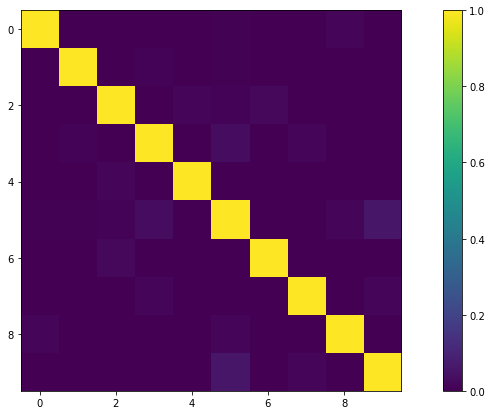

In [81]:
plt.figure(figsize=(15, 7))
plt.imshow(user_pattern)
plt.colorbar()
plt.show()

##### Observations :
1. There is not much correlation amonst the first 10 users. 
2. There is litte correlation between user 5&9. 

## Evaluation

### User Similarity Model

In [82]:
## pivot dataframe for test user 
test_df_rating_adjs_user = test.pivot(index='beer_beerid', columns='review_profilename',values='review_overall').T

### Normalise the data 
mean = np.nanmean(test_df_rating_adjs_user, axis=1)
test_df_subtracted_user = (test_df_rating_adjs_user.T-mean).T

# User Similarity Matrix using adjusted cosine similarity
test_user_correlation = 1 - pairwise_distances(test_df_subtracted_user.fillna(0), metric='cosine')
test_user_correlation[np.isnan(test_user_correlation)] = 0
print(test_user_correlation)

[[ 1.          0.          0.         ...  0.04663214  0.
   0.        ]
 [ 0.          1.          0.         ... -0.02252077  0.
   0.        ]
 [ 0.          0.          1.         ...  0.01720052  0.
   0.        ]
 ...
 [ 0.04663214 -0.02252077  0.01720052 ...  1.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          1.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   1.        ]]


In [83]:
### Set negative correlation to 0.
### Get predicted ratings for all test user<-> beer.
test_user_correlation[test_user_correlation<0]=0
test_user_predicted_ratings = (np.dot(test_user_correlation, test_df_rating_adjs_user.fillna(0))).T
test_user_predicted_ratings

array([[0.32119091, 0.2481382 , 0.0588465 , ..., 0.69246153, 1.28747462,
        0.49994983],
       [0.55468093, 0.86191434, 0.10798118, ..., 1.75470996, 1.36562218,
        1.26306037],
       [0.08524839, 0.13183547, 0.20190266, ..., 0.64100094, 1.72670286,
        1.77703987],
       ...,
       [0.09106316, 0.075014  , 0.        , ..., 0.42578889, 0.        ,
        0.        ],
       [0.32883004, 0.05775705, 0.14914865, ..., 0.0784248 , 0.35225936,
        0.        ],
       [0.        , 0.        , 0.00882064, ..., 0.04533031, 0.        ,
        0.        ]])

In [84]:
test_user_predicted_ratings.shape

(6116, 3933)

In [85]:
### Get the final rating only for recommendation
test_user_final_rating = np.multiply(test_user_predicted_ratings,dummy_test)

In [86]:
test_user_final_rating.head()

review_profilename,0110x011,05Harley,100floods,1759Girl,1Adam12,1fastz28,1whiskey,2xHops,321jeff,32hoss32,...,zerofear13,zhanson88,zimm421,zjungleist,zoolzoo,zoso1967,zoso493,zrab11,zuggy9,zymurgy4all
beer_beerid,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,4.759548,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,2.446711,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
### Normalise the test rating within 1-5 range using minmax scaler.
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = test_user_final_rating.copy() 
X = X[X>0]
scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))
print(y)

MinMaxScaler(copy=True, feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [88]:
### test pivot dataframe for validation 
test_ = test.pivot(index='beer_beerid', columns='review_profilename',values='review_overall')

In [89]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [90]:
#### RMSE Calculation for the model based on test data
rmse_user = (sum(sum((test_ - y )**2))/total_non_nan)**0.5
print(rmse_user)

### RMSE is 2.2563

2.2562763019384464


### Item Similarity Model

In [91]:
## pivot dataframe for test user 
test_df_rating_adjs_item = test.pivot(index='beer_beerid', columns='review_profilename',values='review_overall')

### Normalise the data 
mean = np.nanmean(test_df_rating_adjs_item, axis=1)
test_df_subtracted_item = (test_df_rating_adjs_item.T-mean).T

# Item Similarity Matrix
test_item_correlation = 1 - pairwise_distances(test_df_subtracted_item.fillna(0), metric='cosine')
test_item_correlation[np.isnan(test_item_correlation)] = 0
print(test_item_correlation)

[[ 1.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          1.         -0.00985169 ...  0.16770365  0.
   0.        ]
 [ 0.         -0.00985169  1.         ... -0.0774355  -0.10090659
   0.        ]
 ...
 [ 0.          0.16770365 -0.0774355  ...  1.          0.
   0.        ]
 [ 0.          0.         -0.10090659 ...  0.          1.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   1.        ]]


In [92]:
### Set negative correlation to 0.
### Get predicted ratings for all test user<-> beer.
test_item_correlation[test_item_correlation<0]=0
test_item_predicted_ratings = np.dot(test_item_correlation, test_df_rating_adjs_item.fillna(0))
test_item_predicted_ratings

array([[0.        , 0.29790925, 0.00502771, ..., 0.05672385, 0.00732097,
        0.1285396 ],
       [0.03561126, 0.14754631, 0.09973841, ..., 0.37830863, 0.02699016,
        0.28991294],
       [0.10916063, 0.28754651, 0.        , ..., 0.47692868, 0.13657321,
        0.25746219],
       ...,
       [0.        , 0.        , 0.00835634, ..., 0.47206126, 0.        ,
        0.        ],
       [0.20974276, 0.08073945, 0.33480059, ..., 0.        , 0.04188267,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.142073  , 0.        ,
        0.        ]])

In [93]:
### Get the final rating only for recommendation
test_item_final_rating = np.multiply(test_item_predicted_ratings,dummy_test)

In [94]:
test_item_final_rating.head()

review_profilename,0110x011,05Harley,100floods,1759Girl,1Adam12,1fastz28,1whiskey,2xHops,321jeff,32hoss32,...,zerofear13,zhanson88,zimm421,zjungleist,zoolzoo,zoso1967,zoso493,zrab11,zuggy9,zymurgy4all
beer_beerid,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,4.751757,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,5.238592,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
### Normalise the test rating within 1-5 range using minmax scaler.
X  = test_item_final_rating.copy() 
X = X[X>0]
scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))
print(y)

MinMaxScaler(copy=True, feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [96]:
total_non_nan = np.count_nonzero(~np.isnan(y))

In [97]:
#### RMSE Calculation for the model based on test data
rmse_item = (sum(sum((test_ - y )**2))/total_non_nan)**0.5
print(rmse_item)

### RMSE is 1.80788

1.8078803027973256


### Rating Recommendation 

#### Rating recommendation based item similiarity

In [98]:
## For cokes
test_item_final_rating['cokes'].sort_values(ascending=False).head(5)

beer_beerid
2043     61.316300
14418    55.136957
5850     53.515005
1712     47.922449
47271    43.202732
Name: cokes, dtype: float64

In [99]:
## For genog
test_item_final_rating['genog'].sort_values(ascending=False).head(5)

beer_beerid
42084    8.500154
38888    8.460367
39514    7.674334
2010     5.977493
674      5.784334
Name: genog, dtype: float64

In [100]:
## For Giblet
test_item_final_rating['giblet'].sort_values(ascending=False).head(5)

beer_beerid
2575     8.199732
17805    7.700645
39043    6.734469
21166    6.122878
17625    6.102716
Name: giblet, dtype: float64

#### Rating Recommendation based on User Similarity 

In [101]:
## For cokes
test_user_final_rating['cokes'].sort_values(ascending=False).head(5)

beer_beerid
10672    15.471791
2093     15.052425
56973    13.482342
837      13.263888
222      12.967048
Name: cokes, dtype: float64

In [102]:
## for Genog
test_user_final_rating['genog'].sort_values(ascending=False).head(5)

beer_beerid
17112    32.108225
34       29.195176
674      13.799201
299      13.614224
42533    13.446949
Name: genog, dtype: float64

In [103]:
## for Giblet
test_user_final_rating['giblet'].sort_values(ascending=False).head(5)

beer_beerid
2751    14.954531
155      9.292481
1790     8.837779
1867     8.284388
2729     7.674624
Name: giblet, dtype: float64

### Summary

Item similarity model has a lower RMSE than user based model.